In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [83]:
class neural(nn.Module):
    def __init__(self):
        super(neural,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.flat=nn.Flatten()
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x=self.flat(x)
        x=self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))
        return x
    def num_flat_features(self,x):
        size=x.size()[1:]
        num_features=1
        print(size)
        for s in size:
            num_features*=s
        return num_features
net=neural()
net

neural(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [85]:
x=torch.randn(1,1,32,32)
out=net(x)
out

tensor([[ 0.0511,  0.0706,  0.1261, -0.0189, -0.0084,  0.0674, -0.0273, -0.0186,
         -0.0117, -0.1210]], grad_fn=<AddmmBackward0>)

In [76]:
net.zero_grad()
out.backward(torch.randn(1,10))

In [77]:
out

tensor([[ 0.0318,  0.0583, -0.0021,  0.0046,  0.0891, -0.0577,  0.0437,  0.0744,
         -0.1049,  0.0579]], grad_fn=<AddmmBackward0>)

In [79]:
output = net(x)
target=torch.randn(10).view(1,-1)
crit=nn.MSELoss()
loss = crit(output, target)
print(loss)

torch.Size([16, 5, 5])
tensor(0.7509, grad_fn=<MseLossBackward0>)


In [80]:
net.zero_grad()
print(net.conv1.bias.grad)
loss.backward()
print(net.conv1.bias.grad)

tensor([0., 0., 0., 0., 0., 0.])
tensor([-0.0088, -0.0048, -0.0014, -0.0009, -0.0010,  0.0002])


In [81]:
learn_rate=0.01
for f in net.parameters():
    f.data.sub_(f-learn_rate*f.grad.data)

In [82]:
import torch.optim as optim
optimzer=optim.SGD(net.parameters(),lr=0.01)
optimzer.zero_grad()
output=net(x)
loss=crit(output,target)
loss.backward()
optimzer.step()

torch.Size([16, 5, 5])


In [88]:
pre=nn.Softmax(dim=1)(net(x))
y=pre.argmax(1)
y.item()

2

# 图像分类


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
trainset=torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset=torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
trainLoader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testLoader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog   car   cat truck


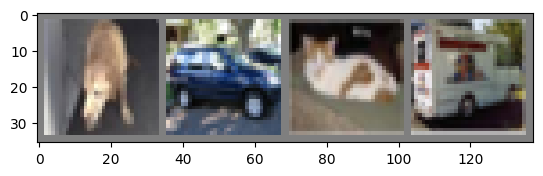

In [24]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img=img/2+0.5
    nping=img.numpy()
    plt.imshow(np.transpose(nping,(1,2,0)))
dataiter=iter(trainLoader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
class neural(nn.Module):
    def __init__(self):
        super(neural,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.flat=nn.Flatten()
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.flat(x)
        # x = x.view(-1, 16 * 5 * 5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=neural()
net

neural(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [26]:
import torch.optim as optim
crit=nn.CrossEntropyLoss()
optimzer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [27]:
total,correct=0,0
for epoch in range(10):
    running_loss=0.0
    for i,data in enumerate(trainLoader,0):
        inputs,labels=data
        optimzer.zero_grad()
        outputs=net(inputs)
        loss=crit(outputs,labels)
        loss.backward()
        optimzer.step()
        running_loss+=loss.item()
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / 12001))
    running_loss = 0.0
    print(f"准确率：{correct/total}")
print("finishing training")


[1] loss: 1.769
准确率：0.37562
[2] loss: 1.394
准确率：0.44768
[3] loss: 1.253
准确率：0.48961333333333334
[4] loss: 1.163
准确率：0.519305
[5] loss: 1.087
准确率：0.541372
[6] loss: 1.025
准确率：0.55991
[7] loss: 0.975
准确率：0.5755914285714285
[8] loss: 0.935
准确率：0.5890575
[9] loss: 0.897
准确率：0.6010888888888889
[10] loss: 0.863
准确率：0.61159
finishing training


In [115]:
inputs.size(),labels.size(),outputs.size()

(torch.Size([4, 3, 32, 32]), torch.Size([4]), torch.Size([4, 10]))

In [28]:
torch.save(net.state_dict(),"./CNNmodel.pth")

In [29]:
dataiter=iter(testLoader)
images,labels=dataiter.next()
images.size(),labels.size()

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

GroundTruth:    cat  ship  ship plane


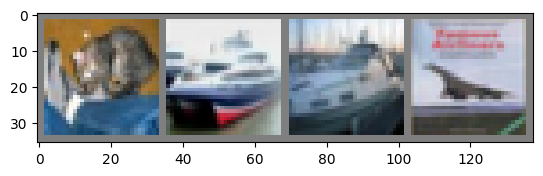

In [30]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
net=neural()
net.load_state_dict(torch.load("./CNNmodel.pth"))
outputs=net(images)
outputs

tensor([[-3.6854, -4.5806, -1.2442,  8.0637, -0.1521,  4.0705,  1.3964, -1.3048,
          1.1213, -3.9181],
        [ 3.8001,  7.6410, -0.3925, -3.7518, -4.2879, -5.6942, -5.1502, -6.3730,
          8.8607,  1.1198],
        [ 2.0054,  1.2810, -0.1252, -0.5392, -0.1219, -0.5374, -2.1950, -0.8549,
          0.7210,  1.4290],
        [ 3.9501, -1.8480,  2.3590,  0.1226, -0.5594, -2.6836, -2.0022, -2.5636,
          2.4543,  0.4164]], grad_fn=<AddmmBackward0>)

In [32]:
_,predicted=torch.max(outputs,1) #返回每一行中的最大元素
_,predicted

(tensor([8.0637, 8.8607, 2.0054, 3.9501], grad_fn=<MaxBackward0>),
 tensor([3, 8, 0, 0]))

In [33]:
[classes[predicted[j]] for j in range(4)]

['cat', 'ship', 'plane', 'plane']

In [34]:
correct=0
total=0
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
with torch.no_grad():
    for data in testLoader:
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        outputs=net(images)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print(correct/total)

0.6353


In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 74 %
Accuracy of  bird : 38 %
Accuracy of   cat : 42 %
Accuracy of  deer : 58 %
Accuracy of   dog : 60 %
Accuracy of  frog : 72 %
Accuracy of horse : 65 %
Accuracy of  ship : 75 %
Accuracy of truck : 73 %
